In [ ]:
# Colab setup

# Setup NASLib
#%cd /content
#!git clone -b zerocost https://github.com/automl/NASLib/
#!pip install gdown

In [1]:
# Download zc score files
#%cd NASLib
#!source scripts/bash_scripts/download_nbs_zero.sh all
#%cd ..

In [1]:
import importlib

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import os
import pandas as pd


from zc_combine.utils.naslib_utils import parse_scores, load_search_space, load_search_spaces_multiple
from zc_combine.ensemble.filter import common_n_largest, filter_by_zc
from zc_combine.utils.plot_utils import plot_common_networks, plot_accuracy_histogram, plot_networks_by_zc, plot_top_accuracy_zc, plot_filtered_by_zc
from zc_combine.ensemble.eval import get_stats_zc

naslib_path = '../zero_cost/NASLib'

all_spaces = [os.path.splitext(f)[0] for f in os.listdir(os.path.join(naslib_path, 'naslib/data/')) if '.json' in f]
all_spaces

['zc_transbench101_macro',
 'zc_transbench101_micro',
 'zc_nasbench301',
 'zc_nasbench201',
 'zc_nasbench101']

In [3]:
def filter_and_plot(dfs, filter_zc, rank_zc, benchmark, quantile=0.8, mode='u', key='corr'):
  dfs_filt = {task: filter_by_zc(df, filter_zc, quantile=quantile, mode=mode) for task, df in dfs.items()}
  dfs_stats_f = {task: get_stats_zc(df, rank_zc, filter_index=dfs_filt[task]) for task, df in dfs.items()}

  plot_filtered_by_zc(dfs_stats_f, filter_zc, rank_zc, benchmark, quantile=quantile, key=key)
  return dfs_stats_f

# Transbench101 macro

In [4]:
#what = 'zc_transbench101_micro'
what = 'zc_transbench101_macro'

zc_transbench101_macro = load_search_space(naslib_path, what)
dfs = parse_scores(zc_transbench101_macro)

In [5]:
zc_spaces = load_search_spaces_multiple(naslib_path, all_spaces)# dataset_key='cifar10')
dfs_multiple = parse_scores(zc_spaces)

In [6]:
dfs.keys()

dict_keys(['class_scene', 'class_object', 'autoencoder', 'normal', 'jigsaw', 'room_layout', 'segmentsemantic'])

Some tasks share only few best networks or none!

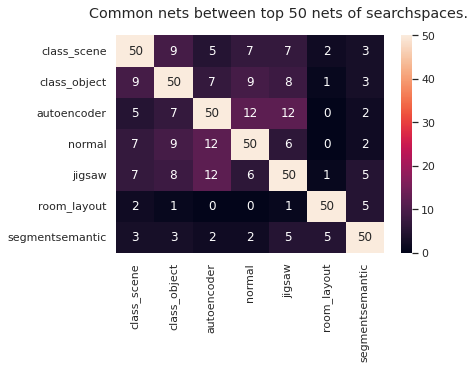

In [6]:
n_largest = 50
inds, common_nets = common_n_largest(dfs, n_largest=n_largest)

plot_common_networks(common_nets, inds, n_largest=n_largest)
plt.show()

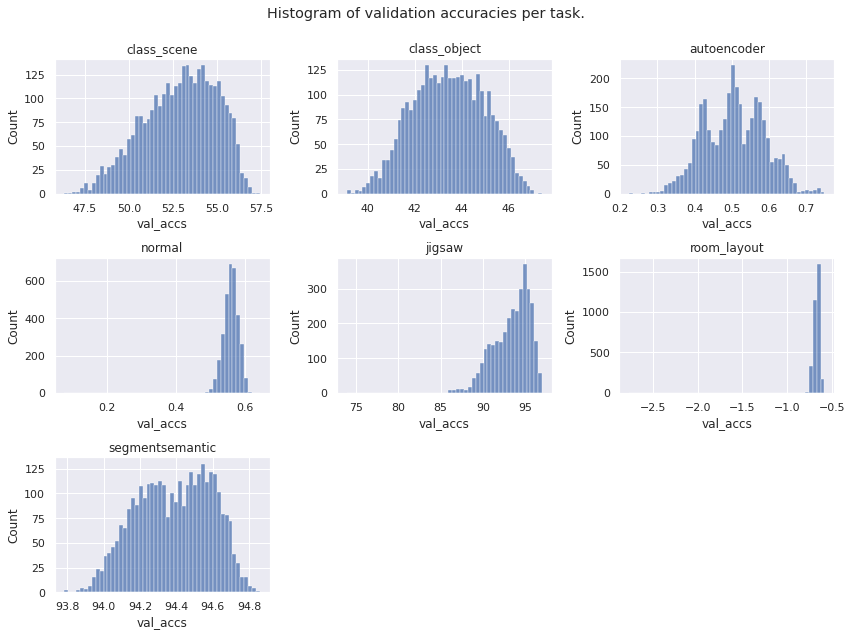

In [7]:
plot_accuracy_histogram({k: v for k, v in dfs.items()})
plt.show()

/home/gabi/.env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gabi/.env/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/gabi/.env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gabi/.env/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/gabi/.env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gabi/.env/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/

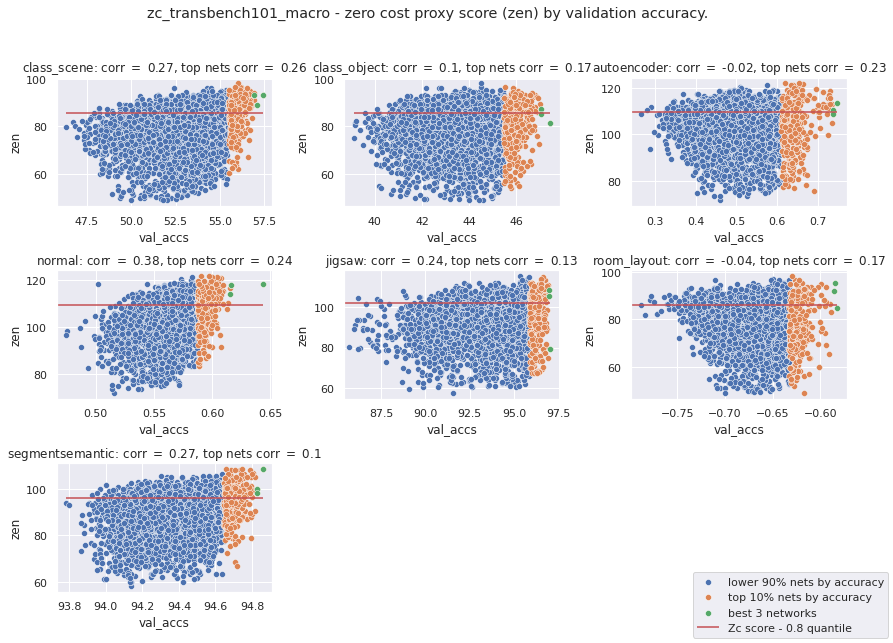

In [6]:
zc = 'zen'
zc_quantile = 0.8

dfs_stats = {task: get_stats_zc(df, zc) for task, df in dfs.items()}

plot_networks_by_zc(dfs_stats, zc, what, top_line=True, subplots_adjust=0.87, zc_quantile=zc_quantile, key='corr')
plt.show()

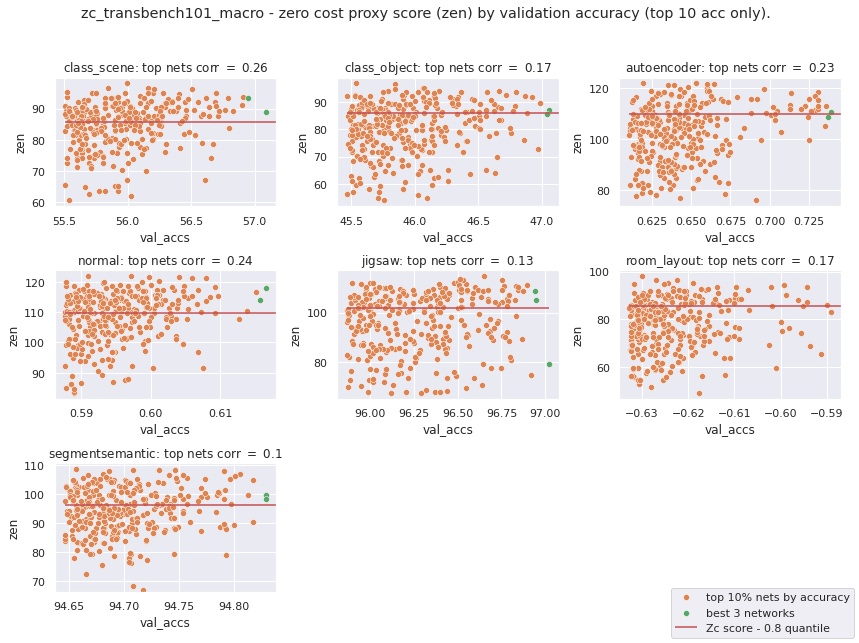

In [7]:
plot_top_accuracy_zc(dfs_stats, zc, what, subplots_adjust=0.87, zc_quantile=zc_quantile, key='corr')
plt.show()


# Combine two proxies

## Combine fisher and nwot

- fisher does not rank well top 10 % networks

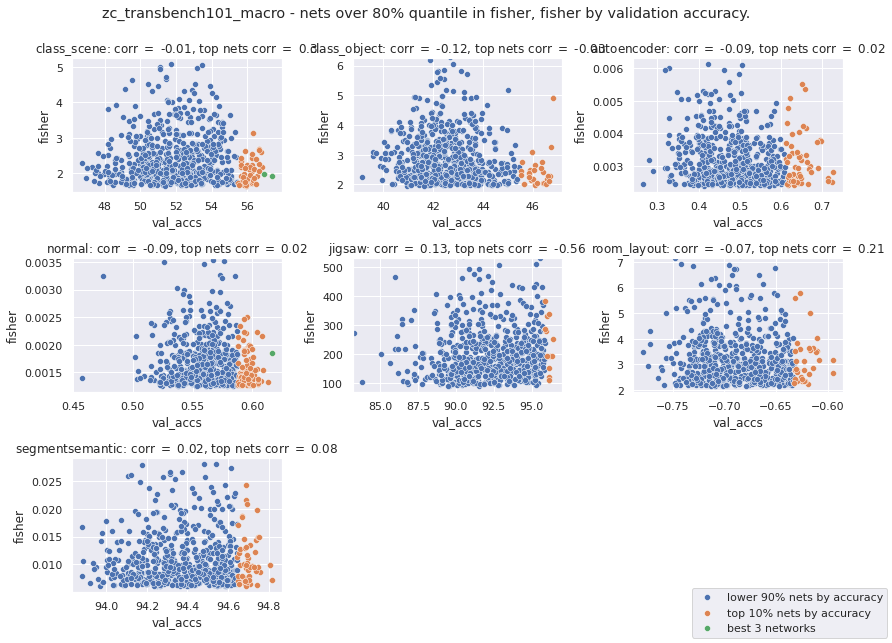

In [13]:
quantile = 0.8

filter_and_plot(dfs, 'fisher', 'fisher', what, quantile=quantile, key='corr')
plt.show()

- nwot is slightly better

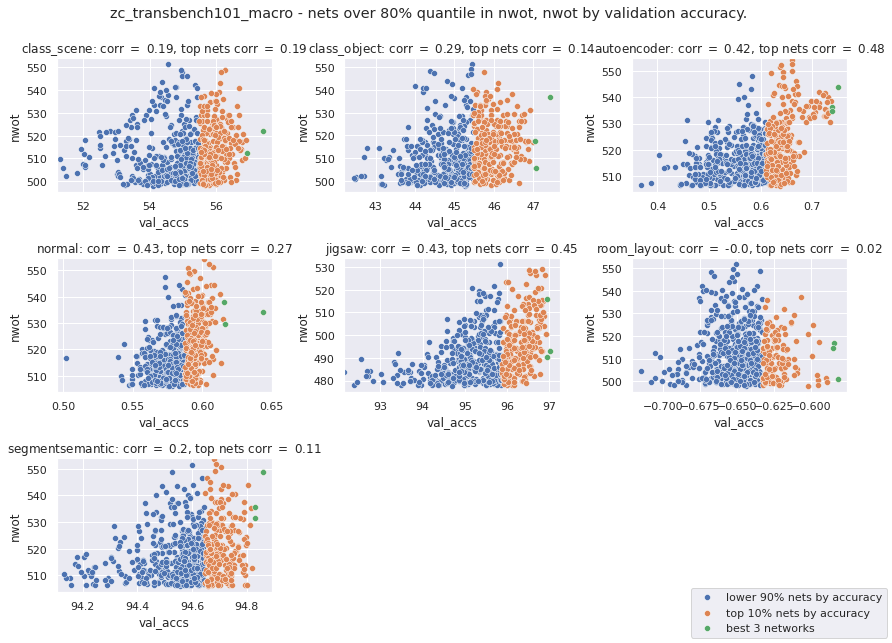

In [14]:
filter_and_plot(dfs, 'nwot', 'nwot', what, quantile=quantile, key='corr')
plt.show()

- select top 10 % networks using fisher
- rank them using nwot
- performance is much better
   - compare with the fisher-fisher case above

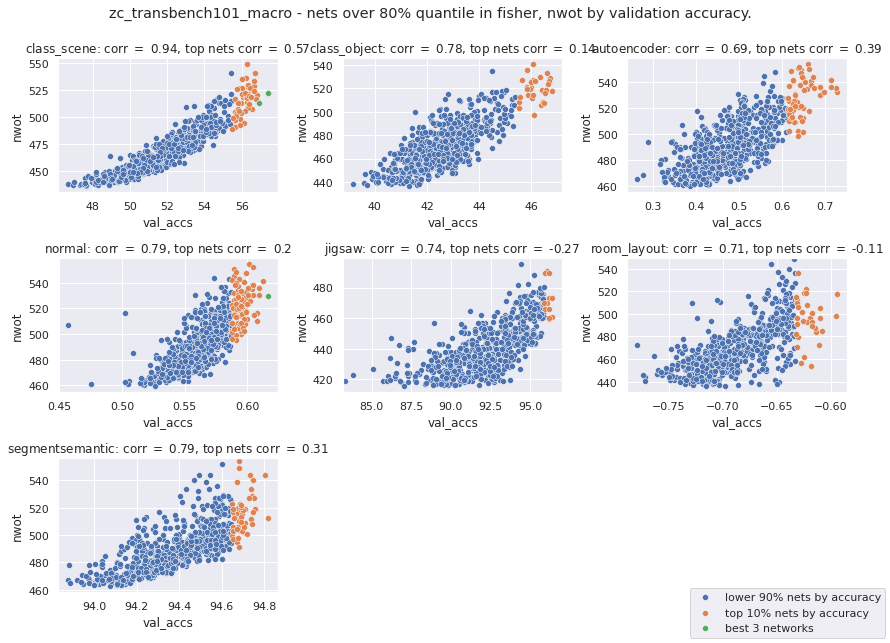

In [15]:
filter_and_plot(dfs, 'fisher', 'nwot', what, quantile=quantile, key='corr')
plt.show()

- reversing the proxies leads to worse results

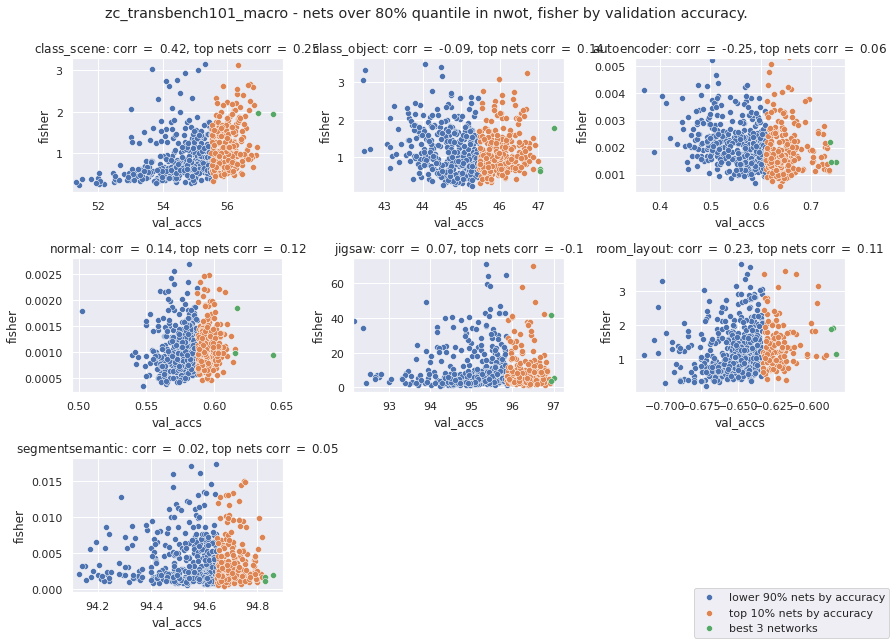

In [16]:
filter_and_plot(dfs, 'nwot', 'fisher', what, quantile=quantile, key='corr')
plt.show()

## Filter using multiple proxies

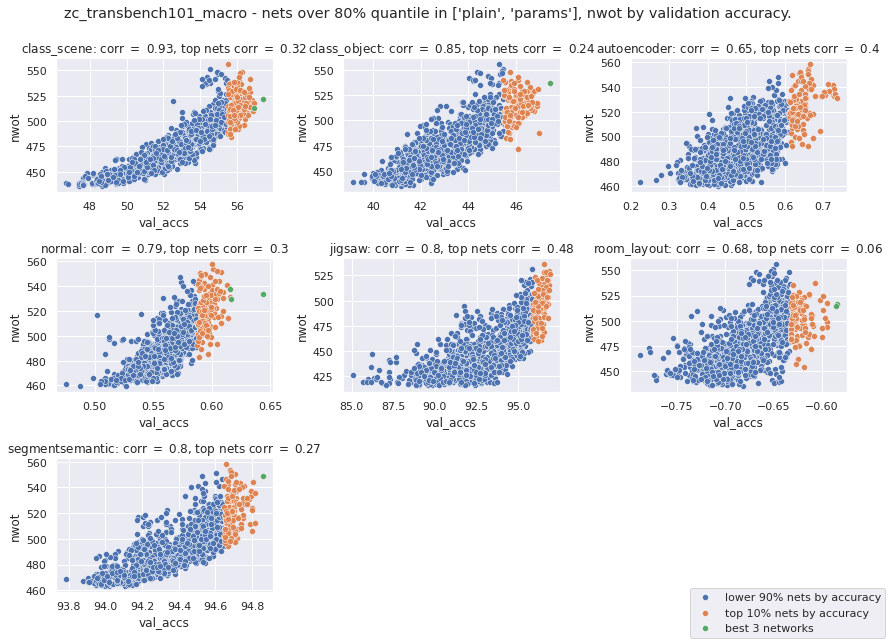

In [17]:
filter_and_plot(dfs, ['plain', 'params'], 'nwot', what, quantile=quantile, key='corr')
plt.show()

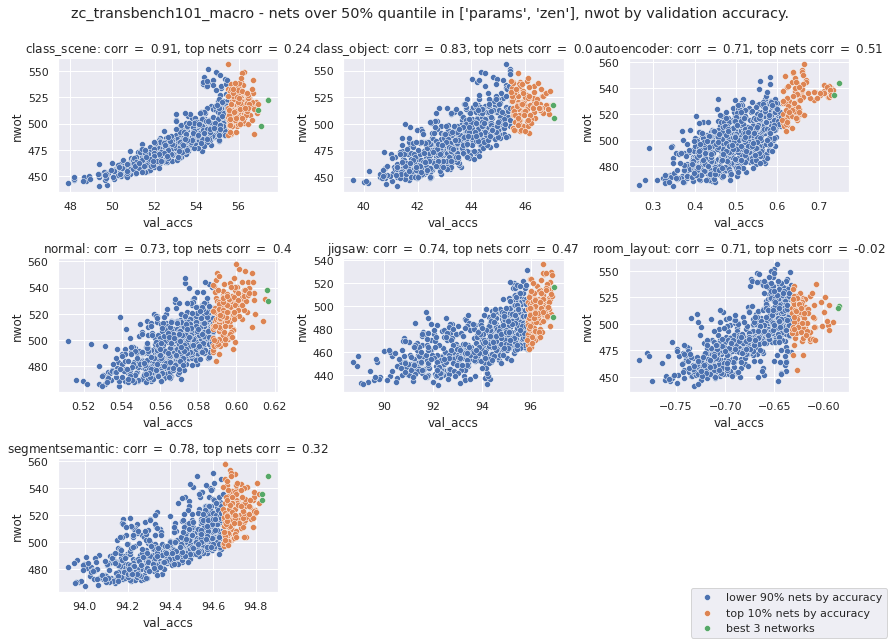

In [17]:
filter_and_plot(dfs, ['params', 'zen'], 'nwot', what, quantile=0.5, key='corr', mode='s')
plt.show()

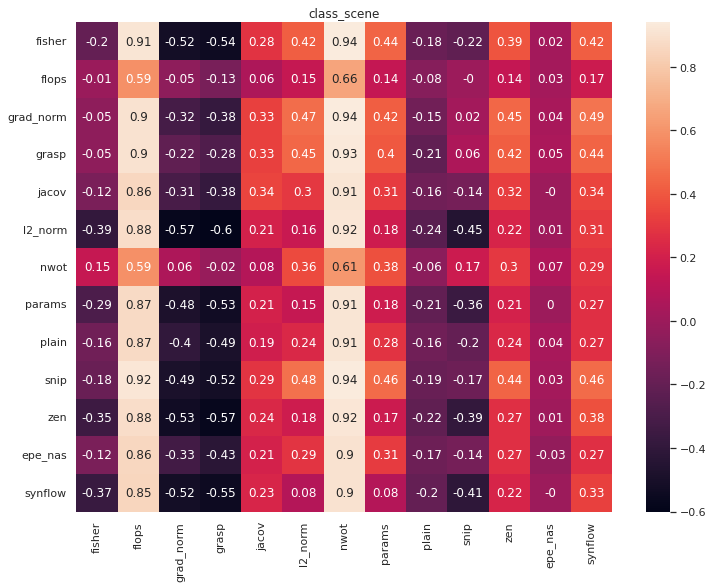

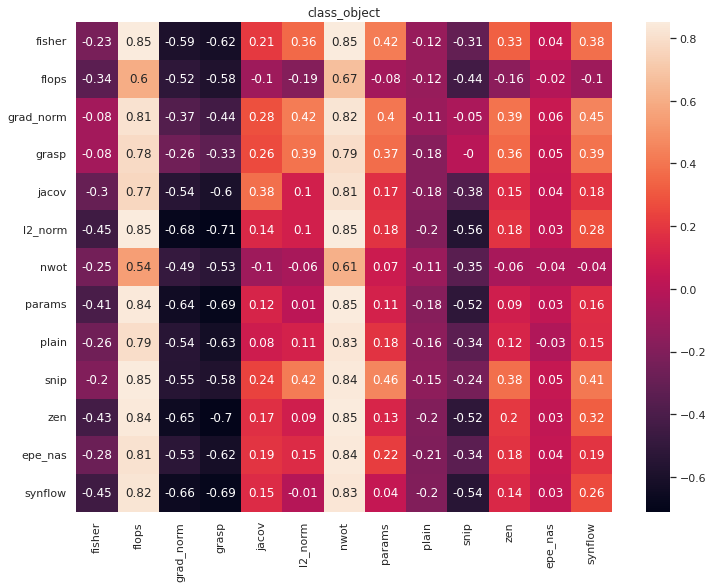

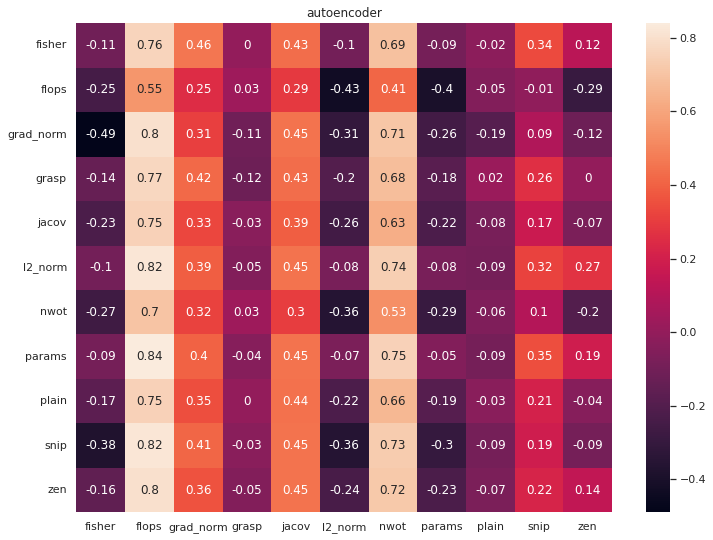

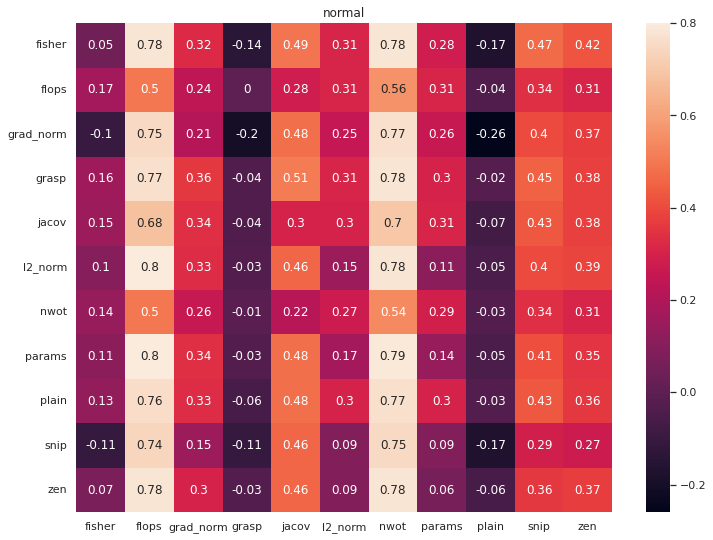

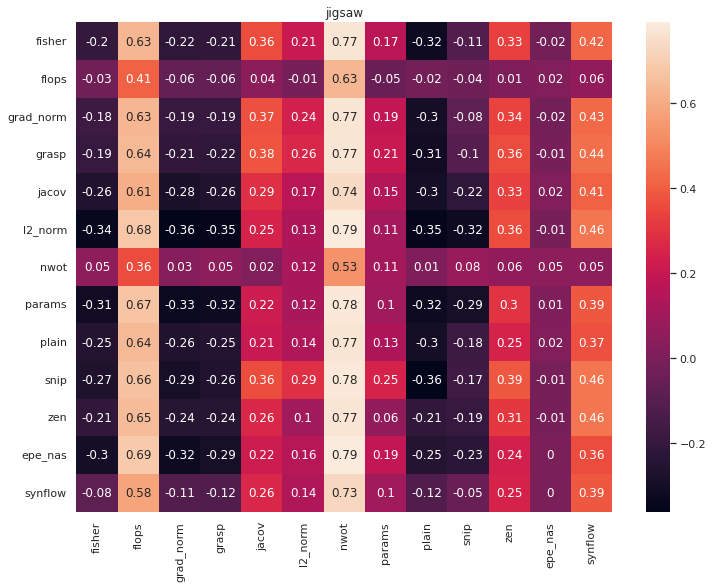

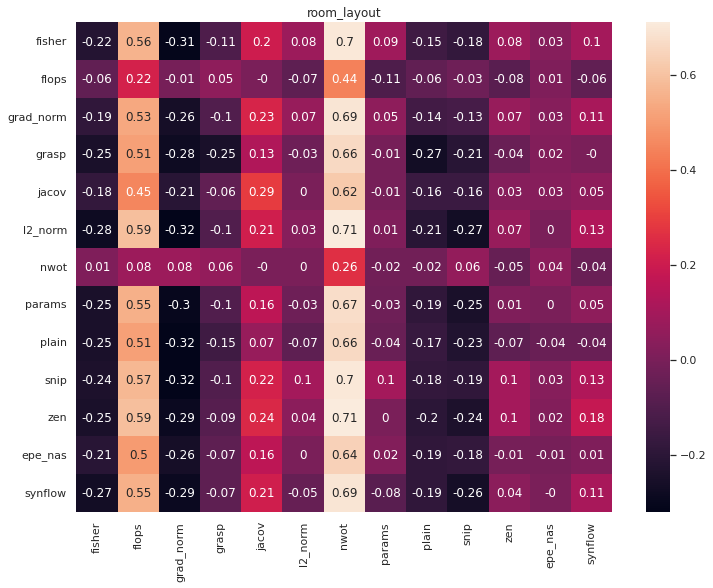

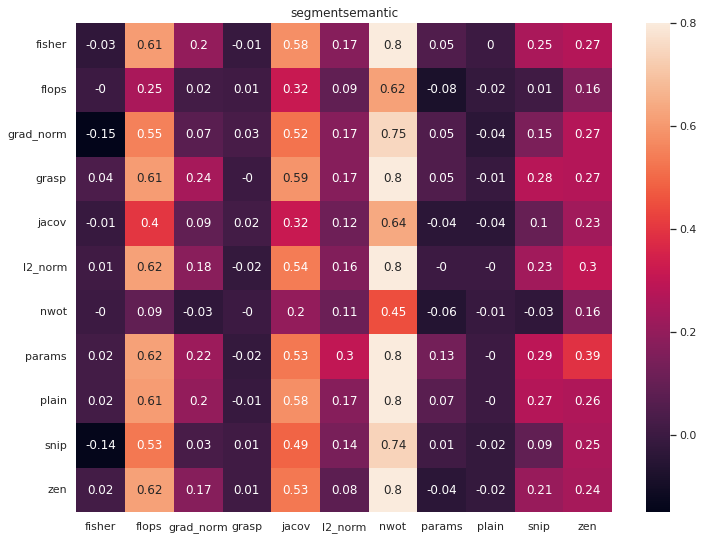

In [18]:
from zc_combine.ensemble.eval import eval_combined_proxies


for task, val in dfs.items():
  inds, tau_scores = eval_combined_proxies(val, key='corr', zc_quantile=0.5)
  names = [inds[i] for i in range(len(inds))]

  plt.figure(figsize=(12,9))
  plt.title(task)
  sns.heatmap(tau_scores, annot=True, xticklabels=names, yticklabels=names)
  plt.show()

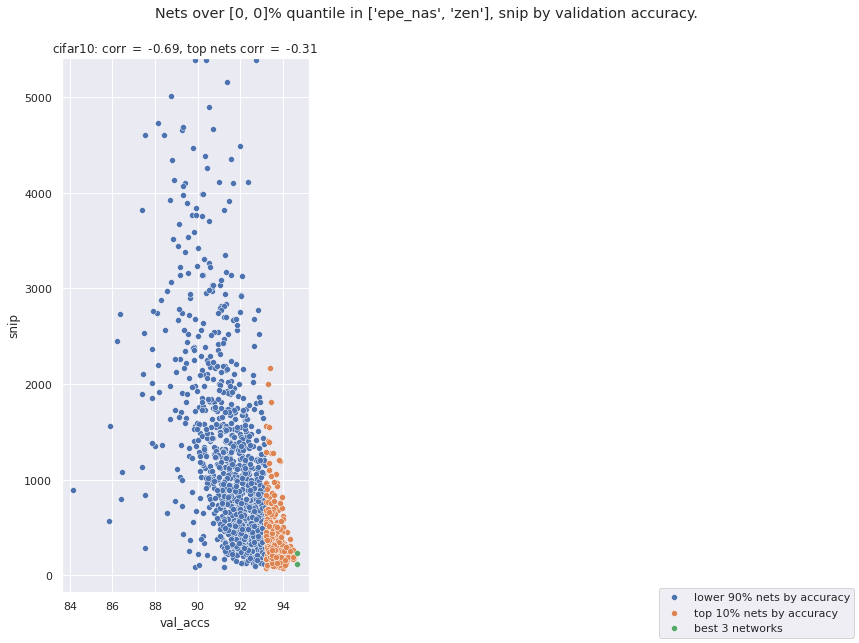

In [94]:
stats, ranks, dfilt = plot_filtered(dfs, ['epe_nas', 'zen'], 'snip', quantile=[0.5, 0.7], key='corr', mode='s')

In [23]:
ae_filt = filter_by_zc(dfs['autoencoder'], 'zen', quantile=0.8)
ae_stats = get_stats_zc(dfs['autoencoder'], 'nwot', filter_index=ae_filt)

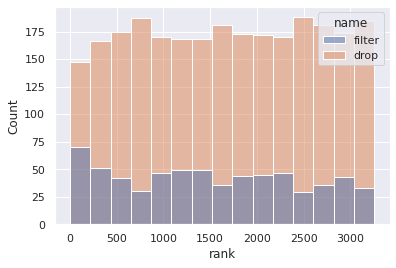

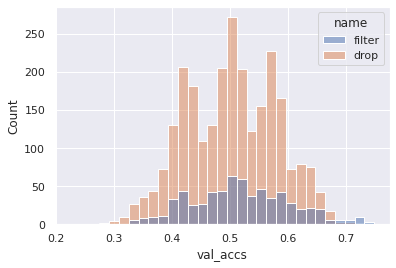

In [26]:
r = ae_stats['stats']

r['ranking_filter']['name'] = 'filter'
r['ranking_drop']['name'] = 'drop'
rdata = pd.concat([r['ranking_filter'], r['ranking_drop']])

sns.histplot(data=rdata, x='rank', hue='name')
plt.show()

sns.histplot(data=rdata, x='val_accs', hue='name')
plt.show()

In [27]:
r['ranking_filter'].sort_values('rank')

,val_accs,rank,name
1840,0.748817,1.0,filter
1091,0.738818,2.0,filter
1764,0.735790,4.0,filter
2852,0.730885,6.0,filter
948,0.730883,7.0,filter
...,...,...,...
2551,0.329057,3229.0,filter
2526,0.328370,3231.0,filter
607,0.327271,3236.0,filter
247,0.289270,3252.0,filter


In [28]:
r['ranking_drop'].sort_values('rank')

,val_accs,rank,name
26,0.737151,3.0,drop
3087,0.735051,5.0,drop
1623,0.725177,13.0,drop
2209,0.724165,15.0,drop
2303,0.707257,21.0,drop
...,...,...,...
305,0.302748,3250.0,drop
2155,0.296982,3251.0,drop
477,0.286802,3253.0,drop
3143,0.264543,3255.0,drop


In [37]:
{k: v for k, v in r.items() if 'rank_median' in k}

{'rank_median': 1470.0, 'rank_median_drop': 1666.0, 'rank_median_full': 1628.5}

In [36]:
{k: v for k, v in r.items() if 'rank_mean' in k}


{'rank_mean': 1507.6927803379417,
 'rank_mean_drop': 1658.6902111324375,
 'rank_mean_full': 1628.5}

In [38]:
{k: v for k, v in r.items() if 'rank_min' in k}

{'rank_min': 1.0, 'rank_min_drop': 3.0, 'rank_min_full': 1.0}